In [1]:
# https://www.kaggle.com/mlwhiz/learning-text-classification-textcnn
# Based on text classification tutorial kernel above
# Used as baseline for further enhancement

In [1]:
# Some imports, we are not gong to use all the imports in this workbook but in subsequent workbooks we surely will.
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf

import gc
import re
import glob

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Define some Global Variables
max_features = 100000 # Maximum Number of words we want to include in our dictionary
maxlen = 72 # No of words in question we want to create a sequence with
embed_size = 300# Size of word to vec embedding we are using
test_split = 0.08 # since datasize is large

In [3]:
# Some preprocesssing that will be common to all the text classification methods you will see. 
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

# Loading the data
def load_and_prec():
    train_df = pd.read_csv("../input/train.csv")
    test_df = pd.read_csv("../input/test.csv")
    
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    train_df["question_text"] = train_df["question_text"].apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    ## split to train and val
    train_df, val_df = train_test_split(train_df, test_size=test_split, random_state=2018) 
    
    ## fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    val_X = val_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values

    ## Tokenize the sentences
    '''
    keras.preprocessing.text.Tokenizer tokenizes(splits) the texts into tokens(words).
    Signature:
    Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True, split=' ', char_level=False, oov_token=None, document_count=0, **kwargs)

    The num_words parameter keeps a prespecified number of words in the text only. 
    It also filters some non wanted tokens by default and converts the text into lowercase.

    It keeps an index of words(dictionary of words which we can use to assign a unique number to a word) 
    which can be accessed by tokenizer.word_index.
    For example - For a text corpus the tokenizer word index might look like. 
    The words in the indexed dictionary are sort of ranked in order of frequencies,
    {'the': 1,'what': 2,'is': 3, 'a': 4, 'to': 5, 'in': 6, 'of': 7, 'i': 8, 'how': 9}
    
    The texts_to_sequence function converts every word(token) to its respective index in the word_index
    
    So Lets say we started with 
    train_X as something like ['This is a sentence','This is another bigger sentence']
    and after fitting our tokenizer we get the word_index as {'this':1,'is':2,'sentence':3,'a':4,'another':5,'bigger':6}
    The texts_to_sequence function will tokenize the sentences and replace words with individual tokens to give us 
    train_X = [[1,2,4,3],[1,2,5,6,3]]
    '''
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences. We need to pad the sequence with 0's to achieve consistent length across examples.
    '''
    We had train_X = [[1,2,4,3],[1,2,5,6,3]]
    lets say maxlen=6
        We will then get 
        train_X = [[1,2,4,3,0,0],[1,2,5,6,3,0]]
    '''
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    val_y = val_df['target'].values  
    
    #shuffling the data
    np.random.seed(2018)
    trn_idx = np.random.permutation(len(train_X))
    val_idx = np.random.permutation(len(val_X))

    train_X = train_X[trn_idx]
    val_X = val_X[val_idx]
    train_y = train_y[trn_idx]
    val_y = val_y[val_idx]    
    
    return train_X, val_X, test_X, train_y, val_y, tokenizer.word_index

In [4]:
%%time
train_X, val_X, test_X, train_y, val_y, word_index = load_and_prec()

Train shape :  (1306122, 3)
Test shape :  (56370, 2)
CPU times: user 1min 57s, sys: 776 ms, total: 1min 58s
Wall time: 1min 59s


In [5]:
# Word 2 vec Embedding

def load_glove(word_index):
    '''We want to create an embedding matrix in which we keep only the word2vec for words which are in our word_index
    '''
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [6]:
embedding_matrix = load_glove(word_index)

In [7]:
# https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [8]:
model = model_cnn(embedding_matrix)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 72, 300)      30000000    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 72, 300, 1)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 1, 36)    10836       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
def train_pred(model, epochs=2):
    filepath="cnn_weights_best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    callbacks = [checkpoint]
    history = model.fit(train_X, train_y, batch_size=512, epochs=epochs, validation_data=(val_X, val_y),callbacks=callbacks)
    model.load_weights(filepath)
    pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_val_y, pred_test_y, history

In [21]:
%%time
pred_val_y, pred_test_y, history = train_pred(model, epochs=8)

Train on 1201632 samples, validate on 104490 samples
Epoch 1/8
1201632/1201632 [==============================] - 234s 195us/step - loss: 0.0847 - acc: 0.9666 - val_loss: 0.1086 - val_acc: 0.9582

Epoch 00001: val_loss improved from inf to 0.10855, saving model to cnn_weights_best.h5
Epoch 2/8
1201632/1201632 [==============================] - 235s 196us/step - loss: 0.0703 - acc: 0.9728 - val_loss: 0.1193 - val_acc: 0.9566

Epoch 00002: val_loss did not improve from 0.10855
Epoch 3/8
1201632/1201632 [==============================] - 234s 195us/step - loss: 0.0550 - acc: 0.9793 - val_loss: 0.1314 - val_acc: 0.9550

Epoch 00003: val_loss did not improve from 0.10855
Epoch 4/8
1201632/1201632 [==============================] - 234s 195us/step - loss: 0.0422 - acc: 0.9845 - val_loss: 0.1517 - val_acc: 0.9537

Epoch 00004: val_loss did not improve from 0.10855
Epoch 5/8
1201632/1201632 [==============================] - 234s 195us/step - loss: 0.0328 - acc: 0.9880 - val_loss: 0.1798 - val

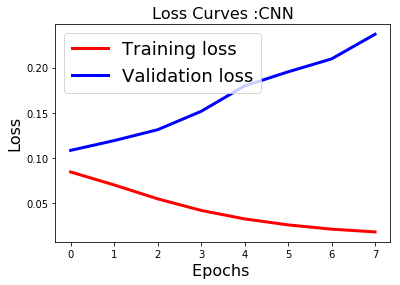

In [22]:
fig1 = plt.figure()
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves :CNN', fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

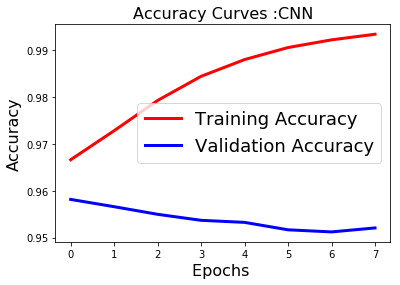

In [23]:
fig1 = plt.figure()
plt.plot(history.history['acc'], 'r', linewidth=3.0)
plt.plot(history.history['val_acc'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves :CNN', fontsize=16)
fig1.savefig('acc_cnn.png')
plt.show()

In [24]:
'''
A function specific to this competition since the organizers don't want probabilities 
and only want 0/1 classification maximizing the F1 score. This function computes the best F1 score by looking at val set predictions
'''

def f1_smart(y_true, y_pred):
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = metrics.f1_score(y_true, (y_pred > thresh).astype(int))
        thresholds.append([thresh, res])
        print("F1 score at threshold {0} is {1}".format(thresh, res))

    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    best_f1 = thresholds[0][1]
    print("Best threshold: ", best_thresh)
    return  best_f1, best_thresh

In [25]:
pred_val_y

array([[1.7467902e-04],
       [3.9537203e-02],
       [8.6469203e-02],
       ...,
       [1.3314816e-03],
       [9.5262706e-01],
       [6.6454482e-04]], dtype=float32)

In [26]:
val_y

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
f1, threshold = f1_smart(val_y, pred_val_y)
print('Optimal F1: {} at threshold: {}'.format(f1, threshold))

F1 score at threshold 0.1 is 0.6052124083971568
F1 score at threshold 0.11 is 0.6132219273979563
F1 score at threshold 0.12 is 0.6196760993602674
F1 score at threshold 0.13 is 0.6277277807187812
F1 score at threshold 0.14 is 0.6326824008625853
F1 score at threshold 0.15 is 0.6368844466114091
F1 score at threshold 0.16 is 0.6414275977445938
F1 score at threshold 0.17 is 0.6455306032584764
F1 score at threshold 0.18 is 0.6491172158837402
F1 score at threshold 0.19 is 0.6527921406411583
F1 score at threshold 0.2 is 0.6541358307682231
F1 score at threshold 0.21 is 0.6556093677436476
F1 score at threshold 0.22 is 0.657626208378088
F1 score at threshold 0.23 is 0.660361954007348
F1 score at threshold 0.24 is 0.6607069178929996
F1 score at threshold 0.25 is 0.661668749132306
F1 score at threshold 0.26 is 0.662038011080721
F1 score at threshold 0.27 is 0.6611874734306362
F1 score at threshold 0.28 is 0.6608919750876942
F1 score at threshold 0.29 is 0.6602012014185424
F1 score at threshold 0.3 

In [17]:
pred_test_y = (pred_test_y >threshold).astype(int)
test_df = pd.read_csv("../input/test.csv", usecols=["qid"])
out_df = pd.DataFrame({"qid":test_df["qid"].values})
out_df['prediction'] = pred_test_y
out_df.to_csv("submission.csv", index=False)

References

Based on mlwhiz's kernel: https://www.kaggle.com/mlwhiz/learning-text-classification-textcnn